## 数据准备

In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

X, _ = make_blobs(cluster_std=1.5, random_state=42, n_samples=1000, centers=3)
X = np.dot(X, np.random.RandomState(0).randn(2, 2))    # 生成斜形类簇

import matplotlib.pyplot as plt
plt.clf()
plt.scatter(X[:,0],X[:,1],alpha=0.3)
plt.show()

<Figure size 640x480 with 1 Axes>

In [ ]:
X_train,X_test=train_test_split(X,test_size=0.2)

n_samples, n_feature = X_train.shape
n_cluster = 3

## 模型基础

### 初始化
首先需要随机初始化$K$个高斯分布。

In [2]:
# # 随机初始化均值，维度为(n_cluster, n_feature)
# # 生成范围/2是为了限制初始均值的生成范围
# mu = np.random.randint(X_train.min()/2, X_train.max()/2, size=(n_cluster, n_feature))

# # 一个协方差矩阵的维度为(n_feature,n_feature)
# # 多个分布的协方差矩阵维度为(n_cluster,n_feature,n_feature)
# cov = np.zeros((n_cluster, n_feature, n_feature))
# for dim in range(len(cov)):
#     np.fill_diagonal(cov[dim], 1)
    
# # 初始均匀的类分布概率
# pi = np.ones(n_cluster)/n_cluster

### E-step
E-step的实质就是根据已有的概率分布计算样本属于各类的概率。

In [3]:
# # 概率矩阵
# P_mat = np.zeros((n_samples, n_cluster))

# for k in range(n_cluster):
#     g = multivariate_normal(mean=mu[k], cov=cov[k])    # 根据均值与方差生成多维分布

#     # 计算X在各分布下出现的频率
#     P_mat[:, k] = p*g.pdf(X_train)

# # 归一化使频率变成概率
# P_mat/=P_mat.sum(axis=1).reshape(-1,1)

### M-step
M-step的实质就是根据样本的归类情况，更新高斯分布的参数。

In [4]:
# # M-step，更新参数
# for k in range(n_cluster):
#     N_k = np.sum(P_mat[:, k], axis=0)    # 类出现的频率
#     mu[k] = (1/N_k)*np.sum(X_train*P_mat[:, k].reshape(-1, 1), axis=0)    # 该类的新均值
#     cov[k] = ((1/N_k)*np.dot((P_mat[:, k].reshape(-1, 1)
#                               * (X_train-mu[k])).T, (X_train-mu[k])))
#     pi[k] = N_k/n_samples

### 预测
各高斯分布的参数训练好之后，预测的实质就是对测试样本再执行一次E-step。

In [5]:
# # 测试集的概率矩阵
# pred_mat=np.zeros((X_test.shape[0], n_cluster))

# # 计算测试样本出现于各类的频率
# for k in range(n_cluster):
#     g=multivariate_normal(mean=mu[k],cov=cov[k])
#     pred_mat[:,k]=pi[k]*g.pdf(X_test)

# # 归一化得到概率
# totol_N = pred_mat.sum(axis=1)
# totol_N[totol_N == 0] = n_cluster
# pred_mat /= totol_N.reshape(-1, 1)

# # 概率最大者为预测值
# Y_pred=np.argmax(pred_mat,axis=1)

## 完整模型

In [6]:
# 随机初始化均值，维度为(n_cluster, n_feature)
# 生成范围/2是为了限制初始均值的生成范围
mu = np.random.randint(X_train.min()/2, X_train.max() /
                       2, size=(n_cluster, n_feature))

# 一个协方差矩阵的维度为(n_feature,n_feature)
# 多个分布的协方差矩阵维度为(n_cluster,n_feature,n_feature)
cov = np.zeros((n_cluster, n_feature, n_feature))
for dim in range(len(cov)):
    np.fill_diagonal(cov[dim], 1)

# 初始均匀的类分布概率
pi = np.ones(n_cluster)/n_cluster

# 概率矩阵
P_mat = np.zeros((n_samples, n_cluster))

from scipy.stats import multivariate_normal    # 生成多维概率分布的方法

max_iter = 20
for i in range(max_iter):
    # 对每一组参数进行计算
    for k in range(n_cluster):
        # 实时生成高斯分布，免去了存储
        g = multivariate_normal(mean=mu[k], cov=cov[k])

    # E-step，计算概率
        # 计算X在各分布下出现的频率
        P_mat[:, k] = pi[k]*g.pdf(X_train)

    # 计算各样本出现的总频率
    totol_N = P_mat.sum(axis=1)
    # 如果某一样本在各类中的出现频率和为0，则使用K来代替，相当于分配等概率
    totol_N[totol_N == 0] = n_cluster
    P_mat /= totol_N.reshape(-1, 1)

    # M-step，更新参数
    for k in range(n_cluster):
        N_k = np.sum(P_mat[:, k], axis=0)    # 类出现的频率
        mu[k] = (1/N_k)*np.sum(X_train *
                               P_mat[:, k].reshape(-1, 1), axis=0)    # 该类的新均值
        cov[k] = ((1/N_k)*np.dot((P_mat[:, k].reshape(-1, 1)
                                  * (X_train-mu[k])).T, (X_train-mu[k])))
        pi[k] = N_k/n_samples


# 迭代更新好参数之后，开始预测未知数据的类
pred_mat = np.zeros((X_test.shape[0], n_cluster))
for k in range(n_cluster):
    g = multivariate_normal(mean=mu[k], cov=cov[k])
    pred_mat[:, k] = pi[k]*g.pdf(X_test)

totol_N = pred_mat.sum(axis=1)
totol_N[totol_N == 0] = n_cluster
pred_mat /= totol_N.reshape(-1, 1)
Y_pred = np.argmax(pred_mat, axis=1)

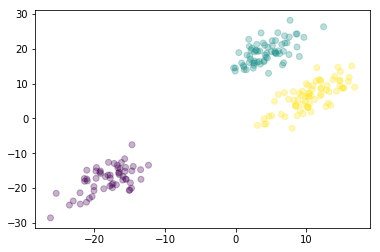

In [7]:
plt.clf()
plt.scatter(X_test[:,0],X_test[:,1],c=Y_pred,alpha=0.3)
plt.show()

## 注意
在GMM模型中存在一个奇异矩阵的问题。回顾多维高斯分布的情况，我们在计算协方差矩阵时的公式为：
$$
\Sigma_{k}=\Sigma_{i}P(c_{k}|x_{i})(x_{i}-\mu_{k})^{T}(x_{i}-\mu_{k})
$$
奇异矩阵问题只有在用户设置的参数$K_{user}$大于数据实际的类数$K$时才有可能发生。在这种情况下，随着参数的不断迭代优化，某一个多余的component可能只包含了单个样本，此时有$x_{i}=\mu_{k}$，那么由上式得到的协方差矩阵为：
$$
\Sigma_{k}=0
$$
再来看生成多维高斯分布的式子：
$$
N(x_{i}|\mu_{k},\Sigma_{k})=\frac{1}{(2\pi)^{n/2}\Sigma_{k}^{1/2}}exp(-\frac{1}{2}(x_{i}-\mu_{k})^{T}\Sigma_{k}^{-1}(x_{i}-\mu_{k}))
$$
如果协方差是奇异的，那么就无法生成多维高斯分布，程序会报错。为了防止出现奇异协方差矩阵，每次在对协方差矩阵操作时人为加上一个微小值。

In [8]:
reg_covar=1e-06